# Introduction

The problem here is price prediction of Airbnb appartments based on the description and the image of the appartment, inputs are the images and the description of the appartment, outputs are typically the price and for the last task we also have the type of the lised item whether it is an appartment, or house or etc.

The impact for this solution is that we can automatically suggest a price for the appartment that is more likely to make it competitive in the market but we need to becareful with the automation part and maybe make it just a suggestion for the user and the user can decide to avoid problems such as those problems that affected Zillow in the USA.

* Text inputs. Cover at least once a GRU/LSTM layer.
* Text inputs. Cover at least once a BiDirectional layer.
* Image inputs. Cover at least once a Conv2d layer.
* Image inputs. Cover at least once a Dropout layer.
* Multi-modality learning. Cover at least once a multi-modality (text+image) model.
* Multi-objective learning. Cover at least once a multi-objective model (predicting both price and type).

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install googletrans==3.1.0a0

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.4 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16352 sha256=d944a6733ff794b6effcca3afa687e7945412c519b09bb85bf221f548a067266
  Stored in directory: /root/.cache/pip/wheels/50/5d/3c/8477d0af4ca2b8b1308812c09f1930863caeebc762fe265a95
Successfully built googletrans
  Attempting uninstall: h11
    Found existing installation: h11 0.14.0
    Uninstalling h11-0.14.0:
      

## Data Preparations

In [3]:
import os
import pandas as pd
from tqdm.notebook import tqdm
from PIL import Image
import numpy as np
from ast import literal_eval
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pprint import pprint
from __future__ import absolute_import, division, print_function, unicode_literals
import collections
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input
from tensorflow.keras.models import Model
from __future__ import absolute_import, division, print_function, unicode_literals
import collections
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
from tensorflow.keras.optimizers import Adam
from googletrans import Translator
from keras.layers import (BatchNormalization, Conv1D, Dense, Input, 
    TimeDistributed, Activation, Bidirectional, SimpleRNN, GRU, LSTM)
import tensorflow.data as tf_data
from keras.layers import Lambda

2024-04-29 19:34:29.649565: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 19:34:29.649697: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 19:34:29.779531: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
test = pd.read_csv("/kaggle/input/cisc-873-dm-w24-a4/a4/test_x.csv")
df = pd.read_csv("/kaggle/input/cisc-873-dm-w24-a4/a4/train_xy.csv")

In [5]:
df.isna().sum()

summary    301
image        0
type         0
price        0
dtype: int64

In [6]:
df

,summary,image,type,price
0,"Spacious, sunny and cozy modern apartment in t...",img_train/0.jpg,Apartment,1
1,Located in one of the most vibrant and accessi...,img_train/1.jpg,Apartment,0
2,Logement coquet et douillet à 10 minutes du ce...,img_train/2.jpg,Apartment,1
3,"Beautiful and spacious (1076 sc ft, / 100 mc) ...",img_train/3.jpg,Apartment,1
4,Très grand appartement ''rustique'' et très ag...,img_train/4.jpg,Apartment,0
...,...,...,...,...
7622,"Un grand logement 4 et 1/2, tout inclut, bien ...",img_train/7626.jpg,Apartment,0
7623,Magnificent condo directly on the river. You w...,img_train/7627.jpg,Apartment,2
7624,This apartment is perfect for anyone visiting ...,img_train/7628.jpg,Apartment,1
7625,"It is a cozy ,clean ,and comfortable apartment...",img_train/7629.jpg,Apartment,0


It seems that the dataset is a mix of different types, so I will translate them into english

In [7]:
df.summary = df.summary.fillna("empty")
df.summary = df.summary.replace("", "empty")

In [8]:
translator = Translator()
df['summary'] = df['summary'].apply(lambda x: translator.translate(x).text)

Let's encode the prediction labels and calculate the total number 
of unique labels. After, lets split the dataset into training set and testing set.

In [9]:
# encoding the categories (labels)
df['type'] = df.type.astype('category').cat.codes
len_price = len(df.price.unique())
len_type = len(df.type.unique())


# get the total number of unique outputs (later used for prediction)
# split data (training/testing set)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=10)

df_test

,summary,image,type,price
3957,empty,img_train/3958.jpg,10,0
6317,Spacious two bedroom apartment in a century-ol...,img_train/6320.jpg,1,1
1122,In the heart of Downtown Montreal. Corner of t...,img_train/1122.jpg,1,1
2640,- One Large bedroom - One bathroom - Fully ren...,img_train/2640.jpg,1,1
4408,Quiet and sunny room in a recent charming cond...,img_train/4410.jpg,1,0
...,...,...,...,...
148,One bedroom in a gorgeous high ceiling apartme...,img_train/148.jpg,1,0
3038,The best location in downtown Montreal! Best d...,img_train/3038.jpg,1,0
5489,"Typical 1930s house, warm, ideal for a family ...",img_train/5492.jpg,17,1
404,Big apartment with a lot of cachet. 4 bedroom...,img_train/404.jpg,1,2


In [10]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify = df.price.values, shuffle = True)

In [11]:
df_train.price.value_counts()

price
0    3789
1    1922
2     390
Name: count, dtype: int64

## Data Preprocessing

We have image and text data. 

- Image data: resize
- Text data: tokenization and converting to integer IDs

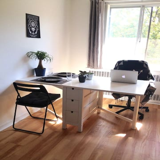

In [12]:
Image.open("/kaggle/input/cisc-873-dm-w24-a4/a4/img_train/5.jpg").resize((160, 160))

In [13]:
# preprocess image data

def load_image(file, shape):
        try:
            image = Image.open(
                file
            ).resize((shape, shape))
            arr = np.array(image)
        except:
            arr = np.zeros((shape, shape, 3))
        return arr


def preprocess_images(shape):


    # loading images:
    path = "/kaggle/input/cisc-873-dm-w24-a4/a4/img_train/"
    x_train_image = np.array([load_image(path + str(i), shape) for i in tqdm(df_train.image)])
    
    return x_train_image

# loading overview: (force convert some of the non-string cell to string)
x_train_text = df_train.summary.astype('str')

# get price 
y_train_price = df_train.price

# get type
y_train_type = df_train.type

x_train_image = preprocess_images(128)

  0%|          | 0/6101 [00:00<?, ?it/s]

In [14]:
# preprocess text data

vocab_size = 40000


# build vocabulary from training set
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(x_train_text)


def _preprocess(list_of_text, max_len = None):
    return pad_sequences(
        tokenizer.texts_to_sequences(list_of_text),
        maxlen = 100,
        padding='post',
    )
    

# padding is done inside: 
x_train_text_id = _preprocess(x_train_text)

print(x_train_text_id.shape)
max_len = x_train_text_id.shape[1]
max_len

(6101, 100)


100

I will also use pretrained Embedding layers later in the experiments and here is the code:

Citing https://keras.io/examples/nlp/pretrained_word_embeddings/

For the following (modified) code.

In [15]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip -q glove.6B.zip

--2024-04-29 19:38:52--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: 'glove.6B.zip'

glove.6B.zip        100%[===================>] 822.24M  5.02MB/s    in 2m 41s  

2024-04-29 19:41:34 (5.09 MB/s) - 'glove.6B.zip' saved [862182613/862182613]



In [16]:
vectorizer = keras.layers.TextVectorization(max_tokens=20000, output_sequence_length=100)
text_ds = tf_data.Dataset.from_tensor_slices(x_train_text).batch(128)
vectorizer.adapt(text_ds)

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [17]:
path_to_glove_file = "/kaggle/working/glove.6B.100d.txt"


def get_embeddings_indexes():
    embeddings_index = {}
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs
            
    return embeddings_index

def initialize_glove(word_index, num_tokens):
    try:
        embeddings_index = get_embeddings_indexes()
        print("Found %s word vectors." % len(embeddings_index))
    except:
        print("didn't find imbeddings file")
        
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        
    return embedding_matrix

num_tokens = len(voc) + 2
embedding_dim = 100

embedding_matrix = initialize_glove(word_index, num_tokens)

Found 400000 word vectors.


In [18]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       ...,
       [ 0.055093  ,  0.87409002, -0.61453003, ...,  0.48194   ,
         0.3504    , -0.53986001],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

## Building a Learning model

In [75]:
# reduce is used to average the embedding layer

class ReduceMeanLayer(Layer):
    def __init__(self, axis=None, **kwargs):
        super(ReduceMeanLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        # Apply the TensorFlow reduce_mean function
        return tf.reduce_mean(inputs, axis=self.axis)

In [76]:
# concat is used to concate the results from 
# different tasks for exampel images and test classification
class ConcatLayer(Layer):
    def __init__(self, axis, **kwargs):
        super(ConcatLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.concat(inputs, axis=self.axis)

In [77]:
from sklearn.utils import class_weight

# calculating the class weights for balanced data
class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y_train_price), y=y_train_price)
class_weights = dict(enumerate(class_weights))

In [22]:
class_weights

{0: 0.5367291281780593, 1: 1.0580992022199098, 2: 5.214529914529915}

In [23]:
def show_learning_curves(history):
    
    f = plt.figure(figsize=(15,5))

    ax1 = plt.subplot(1, 2, 1)

    # plot accuracy and validation accuracy
    plt.plot(history.history.get("SparseCategoricalAccuracy"), label = f"train_accuracy")
    plt.plot(history.history.get("val_SparseCategoricalAccuracy"), label = f"validation_accuracy")

    plt.title('accuracy curves plot'), plt.ylabel('accuracy'), plt.xlabel('epoch')
    plt.legend()

    ax2 = plt.subplot(1, 2, 2, sharey = ax1)

    # plot loss and validation loss
    plt.plot(history.history.get("loss"), label = f"train_loss")
    plt.plot(history.history.get("val_loss"), label = f"validation_loss")

    plt.title('loss curves plot'), plt.ylabel('loss'), plt.xlabel('epoch')
    plt.legend()

# Experiment 1

For the first experiment I will start with a very simple model for text classification, I will use pre trained embedding

In [24]:
embeddins = keras.layers.Embedding(
    num_tokens,
    embedding_dim,
    trainable=False,
)
embeddins.build((1,))
embeddins.set_weights([embedding_matrix])

In [ ]:
in_text = keras.Input(shape=(None,), dtype="int32")

embedded = embeddins(in_text)
rnn = GRU(200, return_sequences= False)(embedded)
dense_rnn = Dense(600)(rnn)
p_price = Dense(len_price, activation='softmax', name='price')(dense_rnn)

# define model input/output using keys.
model = tf.keras.Model(
    inputs=in_text,
    outputs=p_price,
)


# compile model with optimizer, loss values for each task, loss 
# weights for each task.
model.compile(
    optimizer=Adam(),
    loss= ['sparse_categorical_crossentropy'],
    metrics=['SparseCategoricalAccuracy'],
)


model.summary()

history = model.fit(
    x=x_train_text_id,
    y= y_train_price.values,
    epochs=2000,
    batch_size=128,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')
    ],
    verbose=1
)

The model seems to be underfitting, but this might also be irreducible error, it is definitly not overfitting so no variance problem. So to mitigate this problem I will use a model with a more capacity and more complix architecture.

In [ ]:
show_learning_curves(history)

# Experiment 2

In this experiment I will be using LSTM istead of GRU cells and I will be increasing the depth of the model and the number of hidden layers. The layers will also be bidirectional.

In [243]:
embeddins = keras.layers.Embedding(
    num_tokens,
    embedding_dim,
    trainable=False,
)
embeddins.build((1,))
embeddins.set_weights([embedding_matrix])

In [257]:
in_text = keras.Input(shape=(None,), dtype="int32")

embedded = embeddins(in_text)
rnn = Bidirectional(LSTM(256, return_sequences = True))(embedded)
rnn_2 = Bidirectional(LSTM(256))(rnn)
dense_rnn_1 = Dense(512)(rnn_2)
dense_rnn = Dense(256)(dense_rnn_1)
p_price = Dense(len_price, activation='softmax', name='price')(dense_rnn)

# define model input/output using keys.
model_1 = tf.keras.Model(
    inputs=in_text,
    outputs=p_price,
)


# compile model with optimizer, loss values for each task, loss 
# weights for each task.
model_1.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss= ['sparse_categorical_crossentropy'],
    metrics=['SparseCategoricalAccuracy'],
)


model.summary()

history = model_1.fit(
    x=x_train_text_id,
    y= y_train_price.values,
    epochs=2000,
    batch_size=128,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')
    ],
    verbose=1
)

Model: "functional_95"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_66 (InputLayer)     │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_45 (Embedding)        │ (None, None, 100)      │     1,037,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ (None, None, 512)      │       731,136 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_17                │ (None, 512)            │     1,574,912 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ price (Dense)                   │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,738,303 (14.26 MB)

 Trainable params: 2,700,803 (10.30 MB)

 Non-trainable params: 1,037,500 (3.96 MB)

Epoch 1/2000
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 194ms/step - SparseCategoricalAccuracy: 0.5648 - loss: 0.9108 - val_SparseCategoricalAccuracy: 0.6233 - val_loss: 0.8484
Epoch 2/2000
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 180ms/step - SparseCategoricalAccuracy: 0.6146 - loss: 0.8427 - val_SparseCategoricalAccuracy: 0.6233 - val_loss: 0.8568
Epoch 3/2000
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - SparseCategoricalAccuracy: 0.6286 - loss: 0.8368 - val_SparseCategoricalAccuracy: 0.6233 - val_loss: 0.8488
Epoch 4/2000
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 180ms/step - SparseCategoricalAccuracy: 0.6189 - loss: 0.8441 - val_SparseCategoricalAccuracy: 0.6233 - val_loss: 0.8439
Epoch 5/2000
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - SparseCategoricalAccuracy: 0.6255 - loss: 0.8243 - val_SparseCategoricalAccuracy: 0.6233 - val_loss: 0.8419
Epoch 6/2000
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 180ms/step - SparseCategoricalAccuracy: 0.6293 - loss: 0.8273 - val_SparseCategoricalAccuracy: 0.6233 - val_loss: 0.8433
Epoch 7/2000
39

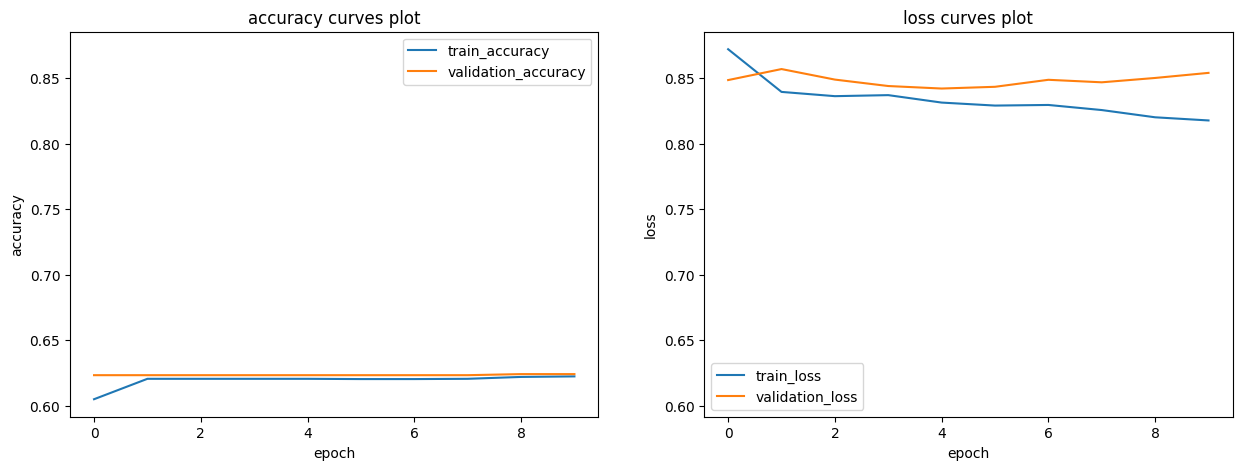

In [259]:
show_learning_curves(history)

It doesn't seem to have improved with deeper model, this might be due to irreducible error with the current data preprocessing steps, so to improve it further we can try to change the embedding stage.

In the next experiment I will be using the Images part, which might be more descriptive than text for this task.

# Experiment 3

In [262]:
in_image = keras.Input(batch_shape=(None, 128, 128, 3))

cov = Conv2D(32, (16, 16))(in_image)
pl = MaxPool2D((16, 16))(cov)
flattened = Flatten()(pl)
dense_2 = Dense(600)(flattened)

p_price = Dense(len_price, activation='softmax', name='price')(dense_2)

model = keras.Model(
    inputs = in_image,
    outputs = p_price,
)

model.compile(
    optimizer=Adam(),
    loss= ['sparse_categorical_crossentropy'],
    metrics=['SparseCategoricalAccuracy'],
)


model.summary()

history = model.fit(
    x = x_train_image,
    y = y_train_price,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5, mode='min')
    ],
    verbose=1,
)

Model: "functional_97"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_67 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 113, 113, 32)   │        24,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 600)            │       941,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ price (Dense)                   │ (None, 3)              │         1,803 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 967,811 (3.69 MB)

 Trainable params: 967,811 (3.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
10/77 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - SparseCategoricalAccuracy: 0.6154 - loss: 1.0353

I0000 00:00:1714400316.711283     100 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - SparseCategoricalAccuracy: 0.6109 - loss: 0.9151 - val_SparseCategoricalAccuracy: 0.6233 - val_loss: 0.8469
Epoch 2/20
 7/77 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - SparseCategoricalAccuracy: 0.5981 - loss: 0.8543

/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_price_loss` which is not available. Available metrics are: SparseCategoricalAccuracy,loss,val_SparseCategoricalAccuracy,val_loss
  current = self.get_monitor_value(logs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - SparseCategoricalAccuracy: 0.6167 - loss: 0.8450 - val_SparseCategoricalAccuracy: 0.6233 - val_loss: 0.8410
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - SparseCategoricalAccuracy: 0.6161 - loss: 0.8378 - val_SparseCategoricalAccuracy: 0.6233 - val_loss: 0.8400
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - SparseCategoricalAccuracy: 0.6205 - loss: 0.8296 - val_SparseCategoricalAccuracy: 0.6233 - val_loss: 0.8437
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - SparseCategoricalAccuracy: 0.6311 - loss: 0.8267 - val_SparseCategoricalAccuracy: 0.6233 - val_loss: 0.8387
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - SparseCategoricalAccuracy: 0.6261 - loss: 0.8315 - val_SparseCategoricalAccuracy: 0.6233 - val_loss: 0.8428
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - SparseCategoricalAccuracy: 0.6219 - loss: 0.8289 - val_SparseCategoricalAccuracy: 0.6233 - val_loss: 0.8420
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms

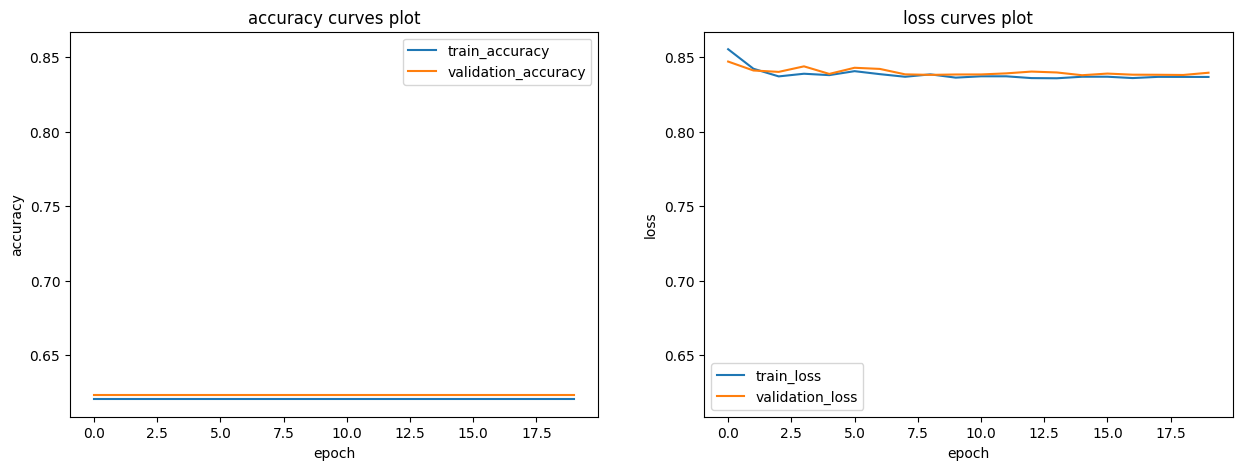

In [263]:
show_learning_curves(history)

Not much improved from the text based model, but maybe trying a deeper model might improve and mitigate underfitting problem.

In the next experiment I will be using VGG-16 model with transfer learning

# Experiment 4

In [15]:
x_train_image = preprocess_images(224)

  0%|          | 0/6101 [00:00<?, ?it/s]

In [17]:
shape = (224, 224, 3)

base_model = tf.keras.applications.VGG19(input_shape=shape,
                                                  include_top=False,
                                                  weights="imagenet")

In [18]:
in_image = keras.Input(batch_shape=(None, 224, 224, 3))
base = base_model(in_image)
flattened = Flatten()(base)
pl = Dropout(0.2)(flattened)
dense_2 = Dense(512)(pl)

p_price = Dense(len_price, activation='softmax', name='price')(dense_2)

model = keras.Model(
    inputs = in_image,
    outputs = p_price,
)

model.compile(
    optimizer=Adam(),
    loss= ['sparse_categorical_crossentropy'],
    metrics=['SparseCategoricalAccuracy'],
)


model.summary()

history = model.fit(
    x = x_train_image,
    y = y_train_price,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5, mode='min')
    ],
    verbose=1,
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ price (Dense)                   │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,871,491 (125.39 MB)

 Trainable params: 32,871,491 (125.39 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


W0000 00:00:1714405908.873449    5330 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/77 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - SparseCategoricalAccuracy: 0.5330 - loss: 16.3445

2024-04-29 15:52:24.502684: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.89842, expected 3.37692
2024-04-29 15:52:24.502744: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.13412, expected 2.61262
2024-04-29 15:52:24.502768: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 3.08377, expected 2.56227
2024-04-29 15:52:24.502785: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 14: 4.1021, expected 3.5806
2024-04-29 15:52:24.502798: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 3.76539, expected 3.24388
2024-04-29 15:52:24.502809: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30: 4.19841, expected 3.6769
2024-04-29 15:52:24.502820: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 63: 3.88366, expected 3.36216
2024-04-29 15:52:24.502831: E external/local_xla/xla

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 734ms/step - SparseCategoricalAccuracy: 0.5336 - loss: 16.2059

W0000 00:00:1714405967.739126    5330 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-04-29 15:52:50.674072: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50176: 3.09291, expected 2.38321
2024-04-29 15:52:50.674142: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50177: 5.88251, expected 5.1728
2024-04-29 15:52:50.674152: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50178: 5.48389, expected 4.77418
2024-04-29 15:52:50.674160: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50179: 5.23066, expected 4.52095
2024-04-29 15:52:50.674168: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50180: 5.78972, expected 5.08001
2024-04-29 15:52:50.674176: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50181: 4.97856, expected 4.26885
2024-04-29 15:52:50.674184: E external/loc

77/77 ━━━━━━━━━━━━━━━━━━━━ 74s 855ms/step - SparseCategoricalAccuracy: 0.5342 - loss: 16.0709 - val_SparseCategoricalAccuracy: 0.6208 - val_loss: 38716808.0000
Epoch 2/20


/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_price_loss` which is not available. Available metrics are: SparseCategoricalAccuracy,loss,val_SparseCategoricalAccuracy,val_loss
  current = self.get_monitor_value(logs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 37s 481ms/step - SparseCategoricalAccuracy: 0.6229 - loss: 1.1307 - val_SparseCategoricalAccuracy: 0.6208 - val_loss: 61990052.0000
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 37s 481ms/step - SparseCategoricalAccuracy: 0.6110 - loss: 0.8481 - val_SparseCategoricalAccuracy: 0.6208 - val_loss: 61843864.0000
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 37s 480ms/step - SparseCategoricalAccuracy: 0.6156 - loss: 0.8332 - val_SparseCategoricalAccuracy: 0.6208 - val_loss: 61841904.0000
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 37s 480ms/step - SparseCategoricalAccuracy: 0.6159 - loss: 0.8387 - val_SparseCategoricalAccuracy: 0.6208 - val_loss: 61848204.0000
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 37s 480ms/step - SparseCategoricalAccuracy: 0.6313 - loss: 0.8364 - val_SparseCategoricalAccuracy: 0.6208 - val_loss: 61805400.0000
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 37s 480ms/step - SparseCategoricalAccuracy: 0.6130 - loss: 0.8491 - val_SparseCategoricalAccuracy: 0.6208 - val_loss: 61831

The model, while it is much more complex than the previous experiment but no further improvement, maybe the model can learn more if we merge both inputs together, the text and images.

# Experiment 5

Based on the previous experimment, I will be using both text and images

In [45]:
x_train_image = preprocess_images(200)

  0%|          | 0/6101 [00:00<?, ?it/s]

In [46]:
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 200, 200, 3))

embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text)
averaged = ReduceMeanLayer(axis = 1)(embedded)

conv_1 = Conv2D(96, 5, 4, activation='relu')(in_image)
pooling_1 = MaxPool2D(pool_size=3, strides=2)(conv_1)
conv_2 = Conv2D(256, 5, activation='relu', padding = 'same')(pooling_1)
pooling_2 = MaxPool2D(pool_size=3, strides=2)(conv_2)
flattened = Flatten()(pooling_2)

# fusion - combinig both
fused = ConcatLayer(axis=1)([averaged, flattened])

# multi-task learning (each is a multi-class classification)
# one dense layer for each task
p_price = Dense(len_price, activation='softmax', name='price')(fused)

# define model input/output using keys.
model = keras.Model(
    inputs={
        'overview': in_text,
        'image': in_image
    },
    outputs = p_price,
)


# compile model with optimizer, loss values for each task, loss 
# weights for each task.
model.compile(
    optimizer=Adam(),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['SparseCategoricalAccuracy']
)


model.summary()


history = model.fit(
    x={
        'overview': x_train_text_id,
        'image': x_train_image
    },
    y={
        'price': y_train_price,
    },
    epochs=1000,
    batch_size=16,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')
    ],
    verbose=1
)

/opt/conda/lib/python3.10/site-packages/keras/src/models/functional.py:112: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'overview' mapping to value <KerasTensor shape=(None, 100), dtype=float32, sparse=None, name=keras_tensor_29> which has name 'keras_tensor_29'. Change the tensor name to 'overview' (via `Input(..., name='overview')`)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/models/functional.py:112: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'image' mapping to value <KerasTensor shape=(None, 200, 200, 3), dtype=float32, sparse=None, name=keras_tensor_30> which has name 'keras_tensor_30'. Change the tensor name to 'image' (via `Input(..., name='image')`)
  warnings.warn(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 49, 49,    │      7,296 │ input_layer_7[0]… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 24, 24,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 24, 24,    │    614,656 │ max_pooling2d_4[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 100, 100)  │  4,000,000 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 11, 11,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduce_mean_layer_3 │ (None, 100)       │          0 │ embedding_4[0][0] │
│ (ReduceMeanLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 30976)     │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer_3      │ (None, 31076)     │          0 │ reduce_mean_laye… │
│ (ConcatLayer)       │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ price (Dense)       │ (None, 3)         │     93,231 │ concat_layer_3[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,715,183 (17.99 MB)

 Trainable params: 4,715,183 (17.99 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
 22/305 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - SparseCategoricalAccuracy: 0.5202 - loss: 1.0743

W0000 00:00:1714420365.278953     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


300/305 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - SparseCategoricalAccuracy: 0.6116 - loss: 0.9037

W0000 00:00:1714420369.451836     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


305/305 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - SparseCategoricalAccuracy: 0.6117 - loss: 0.9028 - val_SparseCategoricalAccuracy: 0.6233 - val_loss: 0.8305
Epoch 2/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - SparseCategoricalAccuracy: 0.6187 - loss: 0.8278 - val_SparseCategoricalAccuracy: 0.6233 - val_loss: 0.8144
Epoch 3/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - SparseCategoricalAccuracy: 0.6177 - loss: 0.8021 - val_SparseCategoricalAccuracy: 0.6249 - val_loss: 0.7910
Epoch 4/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - SparseCategoricalAccuracy: 0.6204 - loss: 0.7689 - val_SparseCategoricalAccuracy: 0.6380 - val_loss: 0.7575
Epoch 5/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - SparseCategoricalAccuracy: 0.6708 - loss: 0.7187 - val_SparseCategoricalAccuracy: 0.6650 - val_loss: 0.7265
Epoch 6/1000
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - SparseCategoricalAccuracy: 0.6864 - loss: 0.6984 - val_SparseCategoricalAccuracy: 0.6765 - val_loss: 0.7096
Epoch 7/1000
305/305 ━━━━━━━

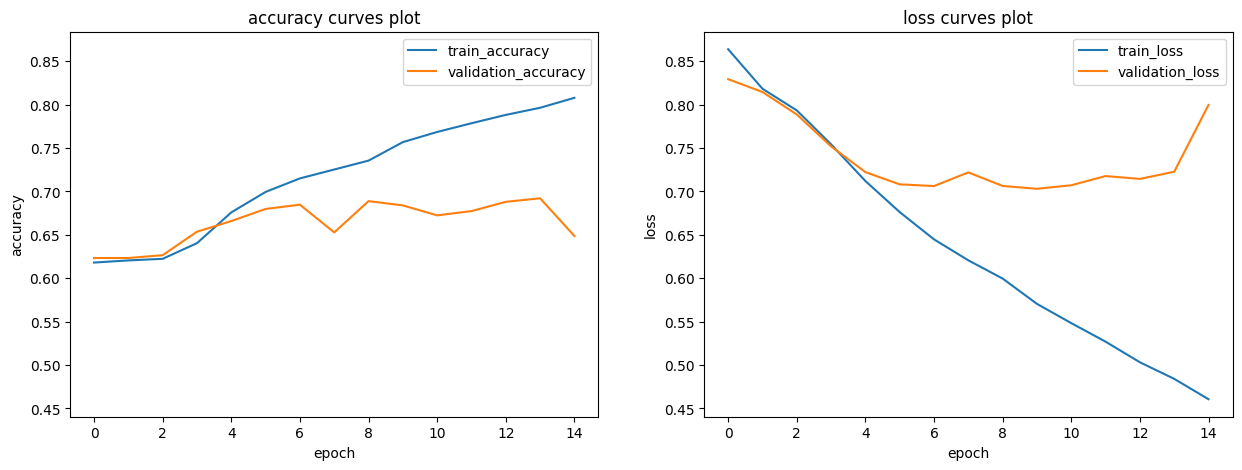

In [27]:
show_learning_curves(history)

It seems that is is overfittinig and might also be underfitting (if this error is not irreducible) so in the next experiment I will be using multi-modal multi-objective but on a much simpler model.

# Experiment 6

In [70]:
x_train_image = preprocess_images(128)

  0%|          | 0/6101 [00:00<?, ?it/s]

In [71]:
in_text = keras.Input(batch_shape=(None, max_len))
in_image = keras.Input(batch_shape=(None, 128, 128, 3))

# text part
# simple average of embedding. you can change it to anything else as needed
embedded = keras.layers.Embedding(tokenizer.num_words, 100)(in_text)

averaged = ReduceMeanLayer(axis = 1)(embedded)


# image part 
# simple conv2d. you can change it to anything else as needed
cov = Conv2D(32, (16, 16))(in_image)
pl = MaxPool2D((16, 16))(cov)
flattened = Flatten()(pl)
# fusion - combinig both
fused = ConcatLayer(axis=-1)([averaged, flattened])

# multi-task learning (each is a multi-class classification)
# one dense layer for each task
p_price = Dense(len_price, activation='softmax', name='price')(fused)
p_type = Dense(len_type, activation='softmax', name='type')(fused)


# define model input/output using keys.
model = keras.Model(
    inputs={
        'overview': in_text,
        'image': in_image
    },
    outputs={
        'price': p_price,
        'type': p_type,
    },
)


# compile model with optimizer, loss values for each task, loss 
# weights for each task.
model.compile(
    optimizer=Adam(),
    loss={
        'price': 'sparse_categorical_crossentropy',
        'type': 'sparse_categorical_crossentropy',
    },
    loss_weights={
        'price': 0.5,
        'type': 0.5,       
    },
    metrics={
        'price': ['SparseCategoricalAccuracy'],
        'type': ['SparseCategoricalAccuracy'],
    },
)


model.summary()

history = model.fit(
    x={
        'overview': x_train_text_id,
        'image': x_train_image
    },
    y={
        'price': y_train_price,
        'type': y_train_type,
    },
    epochs=9,
    batch_size=16,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_price_loss', patience=5, mode='min')
    ],
    verbose=1
)

/opt/conda/lib/python3.10/site-packages/keras/src/models/functional.py:112: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'overview' mapping to value <KerasTensor shape=(None, 100), dtype=float32, sparse=None, name=keras_tensor_40> which has name 'keras_tensor_40'. Change the tensor name to 'overview' (via `Input(..., name='overview')`)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/models/functional.py:112: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'image' mapping to value <KerasTensor shape=(None, 128, 128, 3), dtype=float32, sparse=None, name=keras_tensor_41> which has name 'keras_tensor_41'. Change the tensor name to 'image' (via `Input(..., name='image')`)
  warnings.warn(


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 113, 113,  │     24,608 │ input_layer_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 100, 100)  │  4,000,000 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 7, 7, 32)  │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduce_mean_layer_4 │ (None, 100)       │          0 │ embedding_5[0][0] │
│ (ReduceMeanLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 1568)      │          0 │ max_pooling2d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer_4      │ (None, 1668)      │          0 │ reduce_mean_laye… │
│ (ConcatLayer)       │                   │            │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ price (Dense)       │ (None, 3)         │      5,007 │ concat_layer_4[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ type (Dense)        │ (None, 24)        │     40,056 │ concat_layer_4[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,069,671 (15.52 MB)

 Trainable params: 4,069,671 (15.52 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/9
305/305 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 1.1730 - price_SparseCategoricalAccuracy: 0.6024 - type_SparseCategoricalAccuracy: 0.7538 - val_loss: 0.9557 - val_price_SparseCategoricalAccuracy: 0.6233 - val_type_SparseCategoricalAccuracy: 0.7363
Epoch 2/9
 15/305 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.8485 - price_SparseCategoricalAccuracy: 0.6939 - type_SparseCategoricalAccuracy: 0.7771

/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_price_loss` which is not available. Available metrics are: loss,price_SparseCategoricalAccuracy,type_SparseCategoricalAccuracy,val_loss,val_price_SparseCategoricalAccuracy,val_type_SparseCategoricalAccuracy
  current = self.get_monitor_value(logs)


305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.9254 - price_SparseCategoricalAccuracy: 0.6298 - type_SparseCategoricalAccuracy: 0.7502 - val_loss: 0.9435 - val_price_SparseCategoricalAccuracy: 0.6233 - val_type_SparseCategoricalAccuracy: 0.7363
Epoch 3/9
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.9039 - price_SparseCategoricalAccuracy: 0.6264 - type_SparseCategoricalAccuracy: 0.7518 - val_loss: 0.9209 - val_price_SparseCategoricalAccuracy: 0.6331 - val_type_SparseCategoricalAccuracy: 0.7363
Epoch 4/9
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.8592 - price_SparseCategoricalAccuracy: 0.6317 - type_SparseCategoricalAccuracy: 0.7678 - val_loss: 0.8894 - val_price_SparseCategoricalAccuracy: 0.6511 - val_type_SparseCategoricalAccuracy: 0.7363
Epoch 5/9
305/305 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.8305 - price_SparseCategoricalAccuracy: 0.6730 - type_SparseCategoricalAccuracy: 0.7621 - val_loss: 0.8684 - val_price_SparseCategoricalAccuracy: 0.6757 - val_type_SparseCa

In [73]:
def show_learning_curves(history, acc_1 = "price_SparseCategoricalAccuracy", acc_2 = "val_price_SparseCategoricalAccuracy"):
    
    f = plt.figure(figsize=(15,5))

    ax1 = plt.subplot(1, 2, 1)

    # plot accuracy and validation accuracy
    plt.plot(history.history.get(acc_1), label = f"train_accuracy")
    plt.plot(history.history.get("val_price_SparseCategoricalAccuracy"), label = f"validation_accuracy")

    plt.title('accuracy curves plot'), plt.ylabel('accuracy'), plt.xlabel('epoch')
    plt.legend()

    ax2 = plt.subplot(1, 2, 2, sharey = ax1)

    # plot loss and validation loss
    plt.plot(history.history.get("loss"), label = f"train_loss")
    plt.plot(history.history.get("val_loss"), label = f"validation_loss")

    plt.title('loss curves plot'), plt.ylabel('loss'), plt.xlabel('epoch')
    plt.legend()

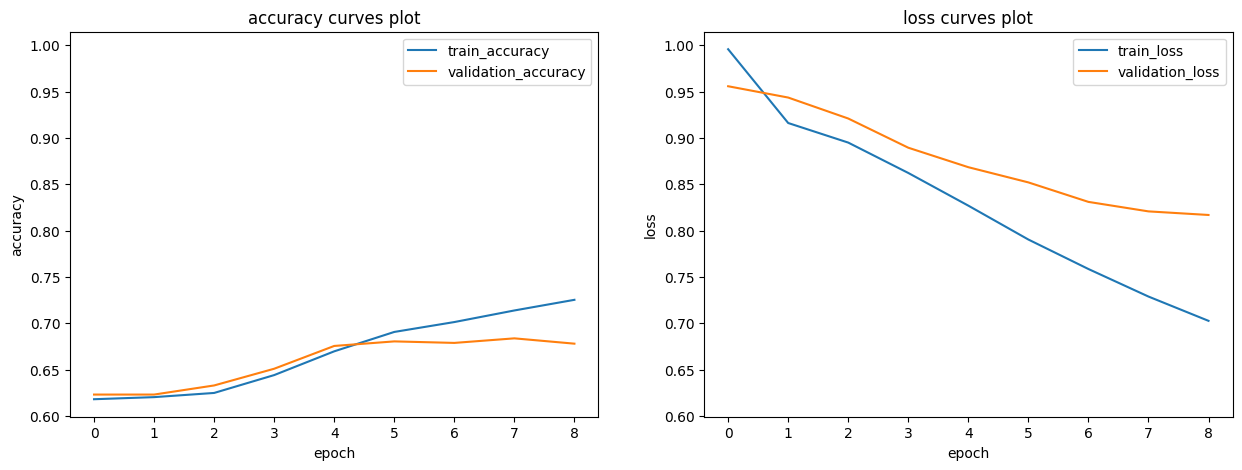

In [74]:
show_learning_curves(history)

## Data Preprocessing (Testing)

Here we use the trained tokenizer to pre-process the testing set.

In [ ]:
data_frame

In [48]:
# loading images:
x_test_image = np.array([load_image(i, 200) for i in tqdm(test.image)])

# loading overview: (force convert some of the non-string cell to string)
x_test_text = _preprocess(test.summary.astype('str'))

  0%|          | 0/7360 [00:00<?, ?it/s]

# Conclusion and Future Work

It is obvious that regradless of the model complexity the results are not improving much, this might mean that the data might be needed to be processed in a different way, for example the images can be augmented before being used with the model.

It is also obvious that Accuracy might not be the best measure sice there is a huge class imbalance, so maybe a better measure can be f1 score or any other measure suitable.

Class imbalance was also handled using class weights, which didn't yeild good results as measured by accuracy.

## Predition

We can use the model to predict the testing samples.

In [44]:
y_predict = model.predict(
    {
        'overview': x_test_text,
        'image': x_test_image
    }
)

230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [66]:
# probabilities
price_predicted = y_predict["price"]
print(price_predicted)

# categories
price_category_predicted = np.argmax(price_predicted, axis=1)
print(price_category_predicted)

[[0.8235535  0.15572868 0.02071782]
 [0.6044594  0.36196214 0.03357844]
 [0.410492   0.5248326  0.06467549]
 ...
 [0.7308451  0.24940106 0.01975387]
 [0.8889141  0.09477661 0.01630924]
 [0.72095907 0.24998653 0.02905441]]
[0 0 1 ... 0 0 0]


In [68]:
#  (if for kaggle competition and it is about price prediction)
pd.DataFrame(
    {'id': test.id,
     'price': price_category_predicted}
).to_csv('regressor.csv', index=False)